In [41]:
# Install These First before Continuing 
%pip install pathlib
%pip install numpy
%pip install pandas
%pip install pillow
%pip install torch
%pip install torchvision
%pip install scikit-learn
%pip install matplotlib

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [42]:
import os
from pathlib import Path
import json
import numpy as np # Import Numpy
import pandas as pd
from PIL import Image
import torch # Import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, models
from sklearn.metrics import roc_curve, auc, r2_score 
import matplotlib.pyplot as plt # Import matplot

In [43]:
# Getting the path of the picture folder which contains the data
BASE_PICTURE_DIR = Path("picture")

# Getting the path of the labels for the JSON 
LABELS_DIR = Path("labels")

# Path to where the improved models are saved
MODEL_DIR = Path("models")
MODEL_DIR.mkdir(exist_ok=True)
MODEL_PATH = MODEL_DIR / "car_count_resnet18.pth"

# hyperparameters
IMAGE_SIZE = 224
BATCH_SIZE = 32
NUM_EPOCHS = 40          
LEARNING_RATE = 1e-4
VAL_SPLIT = 0.2
PATIENCE = 8             
RANDOM_SEED = 42
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [44]:
all_rows = []

if not LABELS_DIR.exists():
    raise FileNotFoundError(f"Labels directory not found: {LABELS_DIR.resolve()}") # Tells us if the directory is not found

for json_path in LABELS_DIR.glob("*_labels.json"):
    with open(json_path, "r", encoding="utf-8") as f:
        data = json.load(f)

    if not isinstance(data, list):
        continue

    for entry in data:
        if entry.get("error") == "YES": # Skips Images that have the label of ERROR
            continue
        if entry.get("car_amount") is None:
            continue

        desc = entry.get("description")
        filename = entry.get("filename")

        # Getting the necessary information such as the name, and description
        path1 = BASE_PICTURE_DIR / desc / filename
        path2 = BASE_PICTURE_DIR / filename

        if path1.exists():
            img_path = path1
        elif path2.exists():
            img_path = path2
        else:
            continue

        all_rows.append({ # Get all of the necessary data in the rows in JSON and pictures
            "filepath": str(img_path),
            "description": desc,
            "filename": filename,
            "car_amount": int(entry["car_amount"]),
            "date": entry.get("date"),
            "time": entry.get("time"),
            "description_total": entry.get("description_total", None)
        })

df = pd.DataFrame(all_rows)
print("Total images", len(df)) # This tells us a total of how many images that have been labeled
df.head()

Total images 314


,filepath,description,filename,car_amount,date,time,description_total
0,picture/2nd_Ave_49_st/2nd_Ave_49_st_1.png,2nd_Ave_49_st,2nd_Ave_49_st_1.png,9,2025-12-08,12-57-30,1
1,picture/2nd_Ave_49_st/2nd_Ave_49_st_2.png,2nd_Ave_49_st,2nd_Ave_49_st_2.png,6,2025-12-08,12-58-30,2
2,picture/2nd_Ave_49_st/2nd_Ave_49_st_3.png,2nd_Ave_49_st,2nd_Ave_49_st_3.png,7,2025-12-08,12-59-30,3
3,picture/2nd_Ave_49_st/2nd_Ave_49_st_4.png,2nd_Ave_49_st,2nd_Ave_49_st_4.png,7,2025-12-08,13-00-30,4
4,picture/2nd_Ave_49_st/2nd_Ave_49_st_5.png,2nd_Ave_49_st,2nd_Ave_49_st_5.png,7,2025-12-08,13-01-30,5


count    314.000000
mean       3.917197
std        2.093537
min        0.000000
25%        3.000000
50%        4.000000
75%        5.000000
max        9.000000
Name: car_amount, dtype: float64


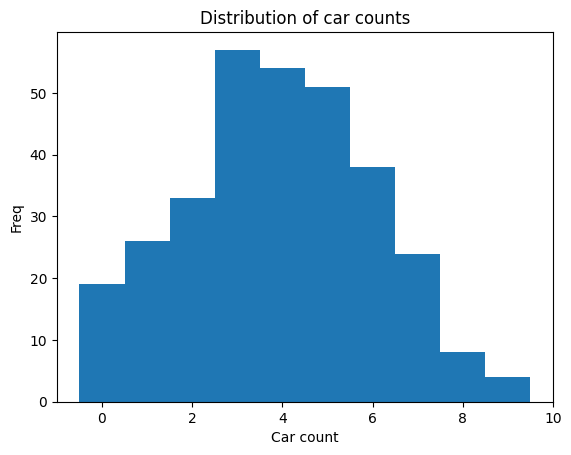

In [46]:
# Get the Distrubtion of the labeled Car Counts and create a graph
print(df["car_amount"].describe())
plt.figure()
plt.hist(df["car_amount"], bins=range(int(df["car_amount"].max()) + 2), align="left")
plt.xlabel("Car count")
plt.ylabel("Freq")
plt.title("Distribution of car counts")
plt.show()

In [47]:
# Transform the Images and their sizes
train_transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

val_transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]), # Transform the Images and their sizes
])


class CarCountDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df.reset_index(drop=True)
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx): 
        row = self.df.iloc[idx]
        img = Image.open(row["filepath"]).convert("RGB") # Transform the Images and their sizes
        if self.transform:
            img = self.transform(img)
        target = torch.tensor(row["car_amount"], dtype=torch.float32)
        return img, target

In [48]:
torch.manual_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

full_dataset = CarCountDataset(df, transform=train_transform) #Tranformation and Full Dataset

val_size = int(len(full_dataset) * VAL_SPLIT)
train_size = len(full_dataset) - val_size

train_dataset, val_dataset_indices = random_split( #Train Databset
    full_dataset,
    [train_size, val_size],
    generator=torch.Generator().manual_seed(RANDOM_SEED)
)

# re-wrap validation
val_df = df.iloc[val_dataset_indices.indices].reset_index(drop=True)
val_dataset = CarCountDataset(val_df, transform=val_transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader   = DataLoader(val_dataset,   batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
len(train_dataset), len(val_dataset)

(252, 62)

In [49]:
def create_resnet18_regressor():
    # Pretrained on ImageNet
    backbone = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)

    # Replace final FC with regression head
    in_features = backbone.fc.in_features
    backbone.fc = nn.Sequential(
        nn.Linear(in_features, 256),
        nn.ReLU(inplace=True),
        nn.Dropout(0.3),
        nn.Linear(256, 1)
    )

    return backbone #Back Bone Return 

model = create_resnet18_regressor().to(device)

criterion = nn.MSELoss() #MSELOSS
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode="min", factor=0.5, patience=3, min_lr=1e-6 #Optimizer and other necessary values needed for training
)

model


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [50]:
def evaluate(model, loader, collect_outputs=False): #Evaluate Model 
    model.eval()
    total_mse = 0.0
    total_mae = 0.0
    n = 0

    all_preds = []
    all_targets = []

    with torch.no_grad():
        for images, targets in loader:
            images = images.to(device)
            targets = targets.to(device)

            outputs = model(images).squeeze(1)  # (batch,)

            loss = criterion(outputs, targets)
            total_mse += loss.item() * targets.size(0)
            total_mae += torch.abs(outputs - targets).sum().item()
            n += targets.size(0)

            if collect_outputs:
                all_preds.append(outputs.cpu().numpy())
                all_targets.append(targets.cpu().numpy())

    mse = total_mse / n
    mae = total_mae / n

    if collect_outputs:
        all_preds = np.concatenate(all_preds)
        all_targets = np.concatenate(all_targets)
        return mse, mae, all_preds, all_targets

    return mse, mae

In [51]:
history = {
    "train_mse": [],
    "train_mae": [],
    "val_mse": [],
    "val_mae": [],
}

best_val_mae = float("inf")
epochs_no_improve = 0

for epoch in range(1, NUM_EPOCHS + 1):
    model.train()
    running_mse = 0.0
    running_mae = 0.0
    n_train = 0

    for images, targets in train_loader:
        images = images.to(device)
        targets = targets.to(device)

        optimizer.zero_grad()
        outputs = model(images).squeeze(1)

        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        batch_size = targets.size(0)
        running_mse += loss.item() * batch_size
        running_mae += torch.abs(outputs - targets).sum().item()
        n_train += batch_size

    train_mse = running_mse / n_train
    train_mae = running_mae / n_train

    val_mse, val_mae = evaluate(model, val_loader)

    history["train_mse"].append(train_mse) #Get the Statistical Numbers for the Training
    history["train_mae"].append(train_mae) #Get the Statistical Numbers for the Training
    history["val_mse"].append(val_mse) #Get the Statistical Numbers for the Training
    history["val_mae"].append(val_mae) #Get the Statistical Numbers for the Training

    scheduler.step(val_mae)

    print(
        f"Epoch {epoch:02d}/{NUM_EPOCHS} | " #Get the Statistical Numbers for the Training
        f"Train MSE: {train_mse:.3f} | Train MAE: {train_mae:.3f} | " #Get the Statistical Numbers for the Training
        f"Val MSE: {val_mse:.3f} | Val MAE: {val_mae:.3f}" #Get the Statistical Numbers for the Training
    )

    # Stops the Epoch training if there is no new best after 8 epoch trainings
    if val_mae < best_val_mae - 1e-3:  # tolerance
        best_val_mae = val_mae
        epochs_no_improve = 0
        torch.save(model.state_dict(), MODEL_PATH)
        print(f"  🔥 New best model saved to {MODEL_PATH}, val MAE = {val_mae:.3f}")
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= PATIENCE:
            print(f"Early stopping after {epoch} epochs (no val MAE improvement for {PATIENCE} epochs).")
            break


Epoch 01/40 | Train MSE: 11.416 | Train MAE: 2.861 | Val MSE: 5.898 | Val MAE: 2.009
  🔥 New best model saved to models/car_count_resnet18.pth, val MAE = 2.009
Epoch 02/40 | Train MSE: 3.782 | Train MAE: 1.501 | Val MSE: 2.182 | Val MAE: 1.181
  🔥 New best model saved to models/car_count_resnet18.pth, val MAE = 1.181
Epoch 03/40 | Train MSE: 1.102 | Train MAE: 0.817 | Val MSE: 2.245 | Val MAE: 1.220
Epoch 04/40 | Train MSE: 1.146 | Train MAE: 0.849 | Val MSE: 1.631 | Val MAE: 1.068
  🔥 New best model saved to models/car_count_resnet18.pth, val MAE = 1.068
Epoch 05/40 | Train MSE: 0.919 | Train MAE: 0.764 | Val MSE: 1.647 | Val MAE: 1.017
  🔥 New best model saved to models/car_count_resnet18.pth, val MAE = 1.017
Epoch 06/40 | Train MSE: 0.764 | Train MAE: 0.665 | Val MSE: 1.907 | Val MAE: 1.115
Epoch 07/40 | Train MSE: 0.566 | Train MAE: 0.552 | Val MSE: 2.011 | Val MAE: 1.140
Epoch 08/40 | Train MSE: 0.680 | Train MAE: 0.620 | Val MSE: 1.758 | Val MAE: 1.046
Epoch 09/40 | Train MSE: 0.

In [52]:
best_model = create_resnet18_regressor().to(device)
best_model.load_state_dict(torch.load(MODEL_PATH, map_location=device))
best_model.eval()

val_mse, val_mae, val_preds, val_targets = evaluate(
    best_model, val_loader, collect_outputs=True # Best Model Numbers for MSE and MAE
)

print(f"Best model: {val_mse:.3f}, MAE: {val_mae:.3f}") # Tells us the best model 
print(f"R^2 score: {r2_score(val_targets, val_preds):.3f}") # Provides us with the R2 Score


Best model: 1.647, MAE: 1.017
R^2 score: 0.678


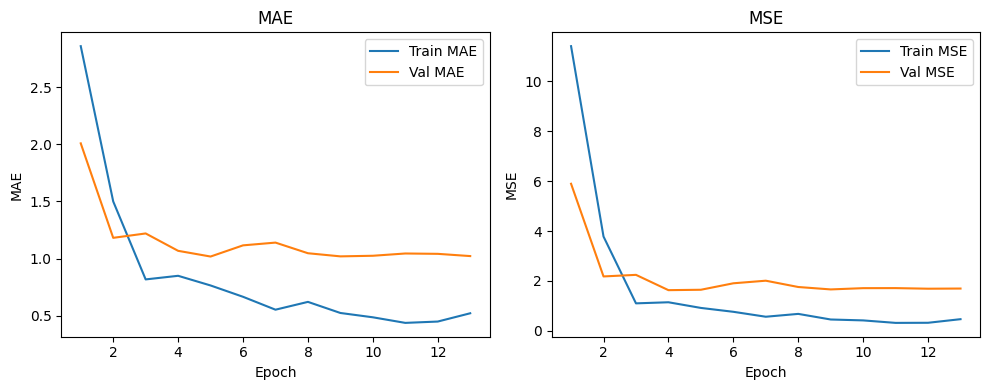

In [53]:
# Get the MAE and MSE Learning Curve
epochs_range = range(1, len(history["train_mse"]) + 1)

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(epochs_range, history["train_mae"], label="Train MAE")
plt.plot(epochs_range, history["val_mae"], label="Val MAE")
plt.xlabel("Epoch")
plt.ylabel("MAE")
plt.title("MAE") # MAE TITLE
plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs_range, history["train_mse"], label="Train MSE")
plt.plot(epochs_range, history["val_mse"], label="Val MSE")
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.title("MSE") # MSE TITLE 
plt.legend()

plt.tight_layout()
plt.show() # Show the two Images


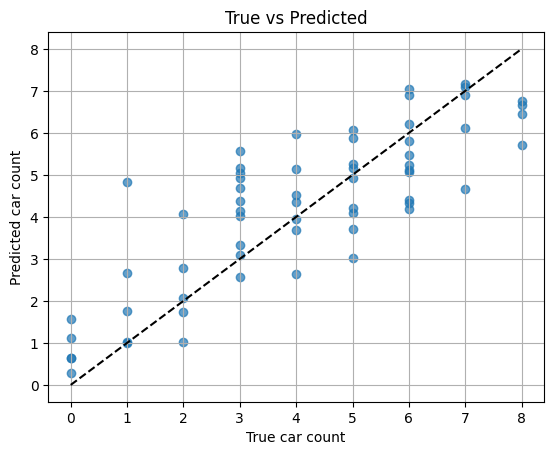

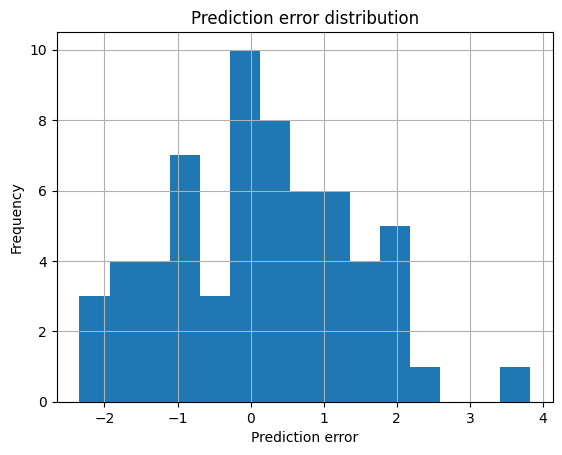

In [54]:
# Scatter: true vs predicted 
plt.figure()
plt.scatter(val_targets, val_preds, alpha=0.7)
max_count = max(val_targets.max(), val_preds.max())
plt.plot([0, max_count], [0, max_count], "k--")
plt.xlabel("True car count")
plt.ylabel("Predicted car count")
plt.title("True vs Predicted")
plt.grid(True)
plt.show()

# Error histogram
errors = val_preds - val_targets
plt.figure()
plt.hist(errors, bins=15)
plt.xlabel("Prediction error")
plt.ylabel("Frequency")
plt.title("Prediction error distribution")
plt.grid(True)
plt.show()


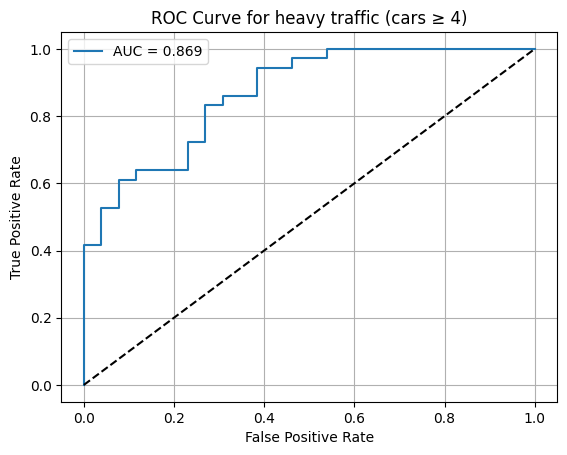

In [55]:
THRESHOLD = 4  # THRESHOLD

y_true_bin = (val_targets >= THRESHOLD).astype(int)
y_scores = val_preds  # Higher Prediction Set

fpr, tpr, thr = roc_curve(y_true_bin, y_scores)
roc_auc = auc(fpr, tpr)
#Create a ROC Curve that showcases heavy traffic data, cars more than 4
plt.figure()
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title(f"ROC Curve for heavy traffic (cars ≥ {THRESHOLD})")
plt.legend()
plt.grid(True)
plt.show()


In [58]:
# Use the same preprocessing as validation
single_image_transform = val_transform  # same as validation


def predict_cars(image_path: str, model=best_model):
    img = Image.open(image_path).convert("RGB")
    x = single_image_transform(img).unsqueeze(0).to(device)
    with torch.no_grad():
        pred = model(x).squeeze(1).item()
    return max(0, int(round(pred)))

# 1) Run model on ALL labeled images
all_true = df["car_amount"].to_numpy()
all_pred = []

for _, row in df.iterrows():
    all_pred.append(predict_cars(row["filepath"]))

all_pred = np.array(all_pred)

# 2) Compute metrics 
mse = np.mean((all_pred - all_true) ** 2)
mae = np.mean(np.abs(all_pred - all_true))
ss_res = np.sum((all_true - all_pred) ** 2)
ss_tot = np.sum((all_true - np.mean(all_true)) ** 2)
r2 = 1 - ss_res / ss_tot

print("=== Final Model Evaluation") # Get the Final Model Evaluation
print(f"Number of samples : {len(all_true)}")
print(f"MSE               : {mse:.3f}")
print(f"MAE               : {mae:.3f}")
print(f"R^2               : {r2:.3f}")
print()

# 3) Show a few random example predictions
num_examples = 10
example_indices = np.random.choice(len(df), size=min(num_examples, len(df)), replace=False)

print("Sample Predictions") #Get a Sample Predictions 
example_rows = []
for i in example_indices:
    row = df.iloc[i]
    example_rows.append({
        "filename": row["filename"],
        "description": row["description"],
        "true_cars": int(all_true[i]),
        "predicted_cars": int(all_pred[i]),
        "error (pred - true)": int(all_pred[i] - all_true[i]),
    })

examples_df = pd.DataFrame(example_rows)
display(examples_df)

=== Final Model Evaluation
Number of samples : 314
MSE               : 0.860
MAE               : 0.573
R^2               : 0.803

Sample Predictions


,filename,description,true_cars,predicted_cars,error (pred - true)
0,Queens_Plaza_North_13.png,Queens_Plaza_North,3,3,0
1,2nd_Ave_49_st_63.png,2nd_Ave_49_st,5,5,0
2,Queens_Midtown_Tunnel_52.png,Queens_Midtown_Tunnel,3,3,0
3,2nd_Ave_49_st_29.png,2nd_Ave_49_st,6,7,1
4,Queens_Midtown_Tunnel_70.png,Queens_Midtown_Tunnel,6,7,1
5,Queens_Midtown_Tunnel_57.png,Queens_Midtown_Tunnel,4,4,0
6,Queens_Plaza_North_67.png,Queens_Plaza_North,2,3,1
7,Queens_Plaza_North_46.png,Queens_Plaza_North,2,2,0
8,Queens_Plaza_North_56.png,Queens_Plaza_North,1,1,0
9,E_63_St_4.png,E_63_St,5,6,1
